<a href="https://colab.research.google.com/github/TonyQ2k3/pytorch-training/blob/main/notebooks/pytorch_day7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Day 7 - Computer Vision with Pytorch
---

## Convolutional Neural Network

A type of deep learning model commonly used for analysing visual data.

Key components:
+ Apply convolutional operations to detect edges and shapes.
+ Hidden layer activation function: ReLU

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
# Download helper function
import requests
from pathlib import Path

if Path("helper_functions.py").is_file() is not True:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

## Getting a dataset

### 1. `torchvision.datasets`

In [3]:
fashion_dataset = datasets.FashionMNIST(
  root='dataset/',
  download=True,
  train=True,
  transform=ToTensor(),
  target_transform=None
)


100%|██████████| 26421880/26421880 [00:01<00:00, 13388971.04it/s]


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212829.22it/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3920651.17it/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6065246.35it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [4]:
fashion_datatest = datasets.FashionMNIST(
    root='dataset',
    download=True,
    train=False,
    transform=ToTensor(),
    target_transform=None
)

In [5]:
# Checking the classes
class_names = fashion_dataset.classes
print(class_names)
print(fashion_dataset.class_to_idx)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [6]:
# Checking the shape
images = fashion_dataset.data
targets = fashion_dataset.targets
print(images.shape)
print(targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [7]:
# Image size
print(images[0].shape)

torch.Size([28, 28])


### 2. Image visualization

In [8]:
# Extract images and labels
images = fashion_dataset.data
labels = fashion_dataset.targets

Text(0.5, 1.0, 'T-shirt/top')

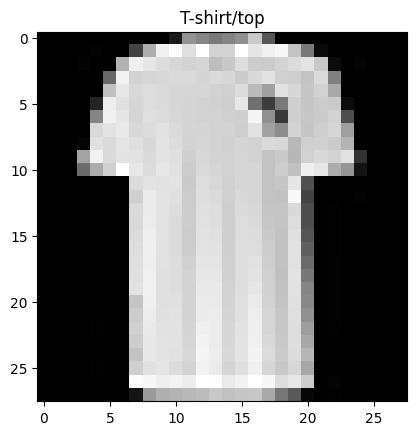

In [9]:
# Visualize using plt.imshow()
index = torch.randint(0, 60000, dtype=torch.int, size=[1]).item()
plt.imshow(X=images[index], cmap='gray')
plt.title(class_names[labels[index]])

## Data preparation

### 1. DataLoader

As of now, our data is a Pytorch dataset.
A dataloader transform it into a Python iterable.
We need to turn our data into batches (aka mini-batches)

### 2. Mini-batches

Reason for batches:
+ Splitting up large dataset makes it more efficient to process
+ batch size = how much data get processed at a time
+ Gives model more time to update gradient per epoch

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=fashion_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=fashion_datatest,
    batch_size=BATCH_SIZE,
    shuffle=True
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79c54dc44190>,
 <torch.utils.data.dataloader.DataLoader at 0x79c54dc44880>)

## Building a Baseline Model

In [11]:
class FashionMnistModelv0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_shape),
        nn.ReLU(),
    )

  def forward(self, x):
    return self.layer_stack(x)

In [12]:
torch.manual_seed(42)
model = FashionMnistModelv0(
  input_shape=28*28,
  hidden_units=10,
  output_shape=len(class_names)
)
model

FashionMnistModelv0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

## Training Process

### Loss functions and Optimizer

Multi-class classification:
+ Loss function: `nn.CrossEntropyLoss()`
+ Optimizer: `torch.optim.SGD()` or `torch.optim.Adam()`
+ Evaluation: Accuracy

In [30]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [41]:
training_losses = []
testing_losses = []

### Training Loop

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [43]:
# Setup progress bar
from tqdm.auto import tqdm


def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_pred = model(X)

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Zero grad
    optimizer.zero_grad()
    # backward
    loss.backward()
    # Step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  training_losses.append(train_loss)
  print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.5f}")


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        testing_losses.append(test_loss)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [44]:
torch.manual_seed(42)

model.to(device)
# Number of epochs
epochs = 10
eps = [x for x in range(1, epochs+1)]

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(dataloader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn
    )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss: 0.81555 | Train Accuracy: 69.51167
Test loss: 0.85292 | Test accuracy: 68.13%

Epoch: 1
---------
Train Loss: 0.81314 | Train Accuracy: 69.62500
Test loss: 0.85563 | Test accuracy: 68.04%

Epoch: 2
---------
Train Loss: 0.81057 | Train Accuracy: 69.58167
Test loss: 0.85608 | Test accuracy: 68.35%

Epoch: 3
---------
Train Loss: 0.80883 | Train Accuracy: 69.63000
Test loss: 0.84868 | Test accuracy: 68.13%

Epoch: 4
---------
Train Loss: 0.80682 | Train Accuracy: 69.66500
Test loss: 0.84659 | Test accuracy: 68.31%

Epoch: 5
---------
Train Loss: 0.80418 | Train Accuracy: 69.79500
Test loss: 0.84556 | Test accuracy: 68.38%

Epoch: 6
---------
Train Loss: 0.80301 | Train Accuracy: 69.88333
Test loss: 0.84517 | Test accuracy: 68.31%

Epoch: 7
---------
Train Loss: 0.80163 | Train Accuracy: 69.86333
Test loss: 0.86297 | Test accuracy: 67.85%

Epoch: 8
---------
Train Loss: 0.80038 | Train Accuracy: 69.86167
Test loss: 0.84098 | Test accuracy: 68.59%

Epoch: 9
-

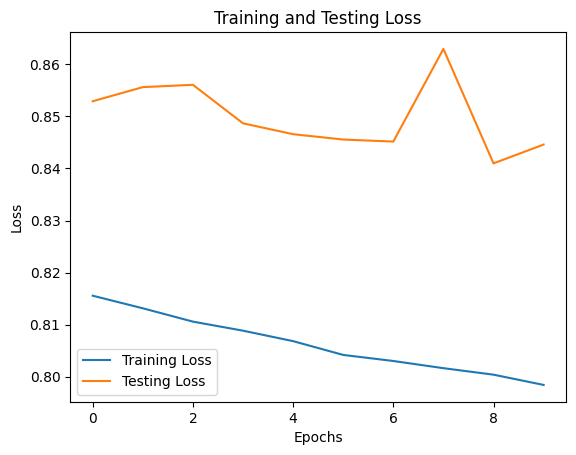

In [45]:
# Visualize train and test losses

x1 = [x for x in range(len(training_losses))]
x2 = [x for x in range(len(testing_losses))]
testing_losses = [loss.cpu().detach().numpy() for loss in testing_losses]

plt.plot(x1, training_losses, label='Training Loss')
plt.plot(x2, testing_losses, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Save the model